In [19]:
#experiment constants
import simpy
import numpy as np
import random
import pandas as pd
from numpy import random
import math

total_links = 20

RTT = np.round(np.random.normal(500,20,total_links))
#RTT = [500]*20
print(RTT)
RTT = [16]*20

failure_rate = np.random.uniform(0.08,0.12,total_links)
#failure_rate = [0.1]*20
print(failure_rate)

failure_constant = sum(failure_rate)/len(failure_rate)

gamma = 1.1/(1-failure_constant)
print(gamma)


[509. 489. 519. 530. 511. 530. 506. 490. 495. 490. 504. 498. 508. 522.
 520. 523. 507. 454. 474. 456.]
[0.08531263 0.08586313 0.11584868 0.1158298  0.08742263 0.08093751
 0.08771255 0.0991187  0.08291654 0.11576629 0.09681492 0.08003385
 0.08937362 0.11256967 0.08493315 0.10962266 0.09943718 0.08204093
 0.09403304 0.09254681]
1.2153443376937982


In [20]:
#srarq


#need to make sender recpetive to feedback
# need to make simulation last not related to time, but when it is complete
class obj_packets():
    def __init__(self, value, retransmissions, link_num, delay, failure_rate, ack):
        self.delay = delay
        self.value = value
        self.retransmissions = retransmissions
        self.link_num = link_num
        self.failure_rate = failure_rate
        self.ack = 1


import simpy
import numpy as np
import random
import pandas as pd



class Cable(object):
    """This class represents the propagation through a cable."""
    def __init__(self, env, packets, failure_rate, links, server):
        self.env = env

        self.store_packets = simpy.Store(env)
        self.store_feedback = simpy.Store(env)
        self.failure_rate = failure_rate
        self.links = links
        self.server= server

    def latency(self, value, type):
        yield self.env.timeout(value.delay)
        if type == 'feedback':
            self.store_feedback.put(value)
        if type == 'packets':
            if self.server == 1:
                if value.retransmissions == 1 or value.retransmissions == 2 or value.retransmissions == 3:
                    value.failure_rate = value.failure_rate/2
                if value.retransmissions == 4:
                     value.failure_rate = value.failure_rate*8
                     value.retransmission = 0

                if random.random() < value.failure_rate:#/(2**(value.retransmissions%3)): #never fails rn but switch
                    value.ack = 0

                self.store_packets.put(value)
            if self.server == 2:
                if value.retransmissions == 1 or value.retransmissions == 2 or value.retransmissions == 3:
                    value.failure_rate = value.failure_rate/2
                if value.retransmissions == 4:
                     value.failure_rate = value.failure_rate*8
                     value.retransmission = 0
                if random.random() < value.failure_rate:#/(2**(value.retransmissions%3)): #never fails rn but switch
                    value.ack = 0
                    #simulates packets in the message dropping, or not dropping

                # FIGURE OUT WHat this does
                self.store_packets.put(value)
                # annoying conversions and store message

    def put(self, value, type):
        # print('put value' + str(value.value))
        self.env.process(self.latency(value, type))

    def get(self,type):
        if type == 'feedback':
            return self.store_feedback.get()
        if type == 'packets':
            return self.store_packets.get()


def sender(env, cable, packets, failure_rate, links, packet_time_increment):
    """A process which randomly generates messages."""
   
    global indicator
    while indicator:
        # if(env.now%1000) == 0:
        #     print("sender")
        global send_time
        global tosend
        global throughput_time
        if not indicator:
            break
        if tosend:
            for i in range(links):
                if tosend:
                    curr_packet_to_send = tosend.pop()
                    #print(curr_packet_to_send.value)
                # add the packets to the message, if they exist

                    if send_time[curr_packet_to_send.value] < 0:
                        send_time[curr_packet_to_send.value] = env.now

                    if min(send_time) != -1 and throughput_time == -1:
                        throughput_time = env.now
                     # if the packet has never been sent, update the send_time array with the first time sent

                    cable.put(curr_packet_to_send, 'packets') # send message through links
        # if(env.now%1000 == 0):
        #     print(env.now)
        yield env.timeout(packet_time_increment) # time increment



# modify after the reciever
def sender_feedback():

    # parameter initiallization
    global indicator
    global end_time
    while True:
        #if(env.now%1000) == 0:
            #print("feedback")
        global tosend
        #print("feedback")
        feedback = yield cable.get('feedback')  # Get event for message pipe
        
        #if there is feedback, adjust the to send stack accordingly
        
        if feedback.delay == 323: 
            #print("access")
            indicator = False
            end_time = env.now-323+(sum(RTT)/(len(RTT)*2))
            break
        # if all packets are in the receiever stack, end the simulation
        else: 
            feedback.retransmissions+=1
            feedback.ack = 1
            tosend.append(feedback)
        # append the stack according

def receiver(env, cable, packets, failure_rate, links):
    
    # parameter initiallization

    while True:
        #if(env.now%1000) == 0:
            #print("reciever")
        global recieve_time # makes times accesible
        global stack_time
        global throughput

        msg = yield cable.get('packets')  # Get event for message pipe
        #print('message_yielded')
        
        if msg is not None:
            #print('msg_recieved')
            if msg.ack ==1:
                recieve_time[msg.value] = env.now
                throughput.append(env.now) # when calcualting through put, lets do total/unique in array
                #update stack
                if min(recieve_time) > -1:
                    #print('accessed')
                    cable.put(obj_packets(1, 1,1, 323, 1, 1), 'feedback')
                    break
            #send back
            else:
                #print(msg.value)
                cable.put(msg, 'feedback')

In [21]:

# DAta collection

total_results_IOD_1 = []
total_results_PPD_1 = []
total_results_time_1 = []
total_results_goodput_1 = []

total_results_IOD_2 = []
total_results_PPD_2 = []
total_results_time_2 = []
total_results_goodput_2 = []

links = [5,6,7,8,9,10,11,12,13,14,15]

for server in range(1,3):
    for links in range(5,16):
        print(links)
        results_IOD = []
        results_PPD = []
        results_time = []
        for trial_num in range(50):
            # Setup and start the simulation
            #print('SRARQ environment')
            env = simpy.Environment()

            #parameter initialization
            end_time = 0
            throughput = []
            throughput_time = 0
            packets = 10000

            failure_rate = failure_rate
            
            packet_time_increment = 1


            send_time = [-1]*packets
            recieve_time = [-1]*packets
            stack_time = []
            indicator = True
            tosend = []
            
            if server == 1:
                for i in range(packets):
                    tosend.append(obj_packets(packets-1-i, 0, i%links, RTT[i%links]/2, failure_rate[i%links], 1))
            if server == 2:
                for i in range(packets):
                    index = 19 - (i%links)
                    tosend.append(obj_packets(packets-1-i, 0, i%links, RTT[index]/2, failure_rate[index], 1))

            #def __init__(self, value, retransmissions, link_num, packet_id):

            # SimPy set up
            cable = Cable(env, packets, failure_rate, links, 1)
            env.process(sender(env, cable, packets, failure_rate, links, packet_time_increment))
            env.process(sender_feedback())
            env.process(receiver(env, cable, packets, failure_rate, links))

            env.run() # set time if it gets stuck in infinite loop
            
            # IOD, PPD and other calculations

            for index in range(len(recieve_time)):
                if index == 0:
                    stack_time.append(recieve_time[0])
                else:
                    stack_time.append(max(recieve_time[index], max(stack_time)))
            IOD = []
            PPD = []
            for i in range(packets):
                IOD.append(stack_time[i]-send_time[i])
                PPD.append(recieve_time[i]-send_time[i])

            #print(PPD)
            IOD_avg = sum(IOD) / len(IOD)
            PPD_avg = sum(PPD) / len(PPD)

            IOD.sort()
            PPD.sort()
        
            results_time.append(end_time)
            results_IOD.append(IOD_avg)
            results_PPD.append(PPD_avg)

        if server == 1:
            total_results_IOD_1.append(sum(results_IOD)/len(results_IOD))
            total_results_PPD_1.append(sum(results_PPD)/len(results_PPD))
            total_results_time_1.append(sum(results_time)/len(results_time))
            total_results_goodput_1.append(packets/end_time)
        if server == 2:
            total_results_IOD_2.append(sum(results_IOD)/len(results_IOD))
            total_results_PPD_2.append(sum(results_PPD)/len(results_PPD))
            total_results_time_2.append(sum(results_time)/len(results_time))
            total_results_goodput_2.append(packets/end_time)


        #fix the throughput times

5
6
7
8
9
10
11
12
13
14
15
5
6
7
8
9
10
11
12
13
14
15


In [22]:
print(total_results_time_1)
print(total_results_PPD_1)

[2236.1, 1865.4, 1603.92, 1408.56, 1254.22, 1135.92, 1035.16, 951.54, 883.5, 822.82, 769.92]
[9.733354000000002, 9.698300000000001, 9.682116, 9.688439999999996, 9.663722, 9.710404, 9.699320000000004, 9.68912, 9.675655999999998, 9.701020000000002, 9.674159999999999]


In [23]:
class obj_packets():
    def __init__(self, link_num, delay, failure_rate, ack, block_id, block_id_value, num_missing):
        self.delay = delay
        self.link_num = link_num
        self.failure_rate = failure_rate
        self.ack = 1
        self.block_id = block_id
        self.block_id_value = block_id_value
        self.num_missing = num_missing

# link = (feedback.link_num + i)%feedback.link_num
# obj_packets((feedback.link_num + i)%feedback.link_num, RTT[link], failure_rate[link], 1, feedback.block_id, m+1-(feedback.num_missing*gamma2-i), 0)
# obj_packets((j*i+j)%links, RTT[(j*i+j)%links], failure_rate[(j*i+j)%links], 1, i, j, 0)


class Cable(object):
    """This class represents the propagation through a cable."""
    def __init__(self, env, packets, failure_rate, links, server):
        self.env = env
        self.store_packets = simpy.Store(env)
        self.store_feedback = simpy.Store(env)
        self.failure_rate = failure_rate
        self.links = links
        self.server= server

    def latency(self, value, type):
        yield self.env.timeout(value.delay)
        if type == 'feedback':
            self.store_feedback.put(value)
        if type == 'packets':
            if self.server == 1:
                if random.random() < value.failure_rate: #never fails rn but switch
                    value.ack = 0

                self.store_packets.put(value)
            if self.server == 2:
                if random.random() < value.failure_rate: #never fails rn but switch
                    value.ack = 0
                    #simulates packets in the message dropping, or not dropping

                # FIGURE OUT WHat this does
                self.store_packets.put(value)
                # annoying conversions and store message

    def put(self, value, type):
        # print('put value' + str(value.value))
        self.env.process(self.latency(value, type))

    def get(self,type):
        if type == 'feedback':
            return self.store_feedback.get()
        if type == 'packets':
            return self.store_packets.get()


def sender(env, cable, packets, failure_rate, links, packet_time_increment):
    """A process which randomly generates messages."""
    global block_send_time
    global indicator
    while indicator:
        #if(env.now%1000) == 0:
            #print("sender")
        global send_time
        global tosend
        global throughput_time
        if not indicator:
            break
        if tosend:
            for i in range(links):
                if tosend:
                    curr_packet_to_send = tosend.pop()
                    #print(curr_packet_to_send.value)
                # add the packets to the message, if they exist

                    if block_send_time[curr_packet_to_send.block_id] < 0:
                        block_send_time[curr_packet_to_send.block_id] = env.now
                     # if the packet has never been sent, update the send_time array with the first time sent

                    cable.put(curr_packet_to_send, 'packets') # send message through links
        # if(env.now%1000 == 0):
        #     print(env.now)
        yield env.timeout(packet_time_increment) # time increment



# modify after the reciever
def sender_feedback():

    # parameter initiallization
    global indicator
    global end_time
    global m
    global gamma2
    global block_num_recieved
    global block_num_total_should_recieve 
    while True:
        # if(env.now%1000) == 0:
        #     print("feedback")
        global tosend
        #print("feedback")
        feedback = yield cable.get('feedback')  # Get event for message pipe
        #print(block_num_recieved)
        
        #if there is feedback, adjust the to send stack accordingly
        
        if feedback.delay == 323: 
            #print("access")
            indicator = False
            end_time = env.now-323+(sum(RTT)/(len(RTT)*2))
            break
        # if all packets are in the receiever stack, end the simulation
        else: 
            for i in range(feedback.num_missing*gamma2):
                block_num_total_should_recieve[feedback.block_id]+=1 #adjust when we send another nack
                link = (feedback.link_num + i)%links 
                tosend.append(obj_packets((feedback.link_num + i)%links, RTT[link]/2, failure_rate[link], 1, feedback.block_id, m-(i+1), 0)) #packet initiailization
        # append the stack according

def receiver(env, cable, packets, failure_rate, links):
    
    # parameter initiallization
    global block_num_recieved
    global block_recieve_time
    global block_num_attempted_to_recieve
    global block_num_total_should_recieve 

    while True:
        msg = yield cable.get('packets')  # Get event for message pipe
        #print('message_yielded')
        if msg is not None:
            #print('msg_recieved')
            block_num_attempted_to_recieve[msg.block_id]+=1
            if msg.ack ==1:
                block_num_recieved[msg.block_id] += 1
                if block_num_recieved[msg.block_id] >= packets_per_block and block_recieve_time[msg.block_id] == -1:
                    block_recieve_time[msg.block_id] = env.now
                
                if min(block_recieve_time) > -1:
                    #print('accessed')
                    cable.put(obj_packets(1, 323,1, 323, 1, 1, 1), 'feedback') #fix
                    break
            #send back
            
            # check if there are any packets left to recieve from the ID, if we need to send a NACK, send it
            if ((block_num_attempted_to_recieve[msg.block_id] == block_num_total_should_recieve[msg.block_id]) and block_recieve_time[msg.block_id] == -1):
                msg.num_missing = packets_per_block - block_num_recieved[msg.block_id]
                #print("missing + " + str(msg.num_missing))
                cable.put(msg, 'feedback')

        
#fix reciever cable


In [24]:
RLNC_total_results_IOD_1 = []
RLNC_total_results_PPD_1 = []
RLNC_total_results_time_1 = []
RLNC_total_results_goodput_1 = []

RLNC_total_results_IOD_2 = []
RLNC_total_results_PPD_2 = []
RLNC_total_results_time_2 = []
RLNC_total_results_goodput_2 = []

links = [5,6,7,8,9,10,11,12,13,14,15]


for server in range(1,3):
    for links in range(5,16):
        print(links)
        results_IOD = []
        results_PPD = []
        results_time = []
        for trial_num in range(50):
            env = simpy.Environment()
            channel_num = 1
            # parameters
            packets = 10000

            packet_time_increment = 1
            end_time = 0
            throughput_time = -1

            failure_constant = sum(failure_rate)/len(failure_rate)

            gamma = 1.1/(1-failure_constant) # gamma
            useful_block = 0
            useful_block_time = 0

            packets_per_block = 8

            n = packets_per_block # packets needed to decode a block
            m = math.ceil(packets_per_block* gamma) # number of packets needed to send per block

            num_blocks = math.ceil(packets/packets_per_block)


            gamma2 = math.ceil(2/(1-failure_constant))
            # if were misssing x packets, we send gamma2 * x to the queue to resend


            num_packets_block_counter = [0]*num_blocks
            #how many packets we have recieved for each block

            # variable the time the block was able to be decoded, and the n packets were recovered.
            block_send_time = [-1]*num_blocks
            block_num_recieved = [0]*num_blocks
            block_num_attempted_to_recieve = [0]*num_blocks
            block_num_total_should_recieve = [m]*num_blocks
            block_recieve_time = [-1]*num_blocks
            block_stack_time = []
            packet_time = [-1]*packets

            # time that the first packet of the block was sent
            indicator = True
            tosend = []

            if server == 1:
                for i in range(num_blocks):
                    for j in range(m):
                        tosend.append(obj_packets((i*m+j)%links, RTT[(m*i+j)%links]/2, failure_rate[(m*i+j)%links], 1, i, j, 0)) 
            if server == 2:
                for i in range(num_blocks):
                    for j in range(m):
                        tosend.append(obj_packets((i*m+j)%links, RTT[19-(m*i+j)%links]/2, failure_rate[19 - (m*i+j)%links], 1, i, j, 0)) 
                


            cable = Cable(env, packets, failure_rate, links, 1)
            env.process(sender(env, cable, packets, failure_rate, links, packet_time_increment))
            env.process(sender_feedback())
            env.process(receiver(env, cable, packets, failure_rate, links))

            env.run()

            block_send_time= block_send_time[::-1]
            block_recieve_time = block_recieve_time[::-1]

            for index in range(len(block_recieve_time)):
                if index == 0:
                    block_stack_time.append(block_recieve_time[0])
                else:
                    block_stack_time.append(max(block_recieve_time[index], max(block_stack_time)))
            # result calculations


            IOD = []
            PPD = []
            for i in range(num_blocks):
                IOD.append(block_stack_time[i]-block_send_time[i])
                PPD.append(block_recieve_time[i]-block_send_time[i])


            IOD_avg = sum(IOD) / len(IOD)
            PPD_avg = sum(PPD) / len(PPD)
            IOD.sort()
            PPD.sort()

            results_time.append(end_time)
            results_IOD.append(IOD_avg)
            results_PPD.append(PPD_avg)
            print(end_time)

        if server == 1:
            RLNC_total_results_IOD_1.append(sum(results_IOD)/len(results_IOD))
            RLNC_total_results_PPD_1.append(sum(results_PPD)/len(results_PPD))
            RLNC_total_results_time_1.append(sum(results_time)/len(results_time))
            RLNC_total_results_goodput_1.append(packets/end_time)


            # we only consider blocks for the ppd, and the time deocded vs the 1st time sent
        if server == 2:
            RLNC_total_results_IOD_2.append(sum(results_IOD)/len(results_IOD))
            RLNC_total_results_PPD_2.append(sum(results_PPD)/len(results_PPD))
            RLNC_total_results_time_2.append(sum(results_time)/len(results_time))
            RLNC_total_results_goodput_2.append(packets/end_time)


        # if server ==1:
        #         graph = pd.read_csv('graphing.csv')
        #         graph.loc[len(graph.index), ['Server Number', 'Num_Channels','Avg_IOD', 'Max_IOD', 'Avg_IFD', 'Max_IFD', 'Throughput','Finish Time']] = [channel_num, links, IOD_avg, IOD[len(IOD)-1],PPD_avg, PPD[len(PPD)-1], packets/throughput_time, end_time]
        #         graph.to_csv("graphing.csv", index=False)
                
        # else:
        #     graph = pd.read_csv('graphing.csv')
        #     graph.loc[len(graph.index), ['Server Number', 'Num_Channels','Avg_IOD', 'Max_IOD', 'Avg_IFD', 'Max_IFD', 'Throughput','Finish Time']] = [channel_num, 10-links, IOD_avg, IOD[len(IOD)-1],PPD_avg, PPD[len(PPD)-1], packets/throughput_time, end_time]
        #     graph.to_csv("graphing.csv", index=False)

5
2570.0
2578.0
2588.0
2581.0
2580.0
2575.0
2570.0
2580.0
2586.0
2559.0
2579.0
2579.0
2560.0
2574.0
2570.0
2575.0
2590.0
2569.0
2582.0
2579.0
2576.0
2558.0
2583.0
2580.0
2586.0
2580.0
2590.0
2581.0
2567.0
2563.0
2572.0
2574.0
2575.0
2573.0
2582.0
2578.0
2571.0
2589.0
2592.0
2574.0
2580.0
2583.0
2572.0
2577.0
2576.0
2571.0
2578.0
2576.0
2580.0
2583.0
6
2149.0
2139.0
2151.0
2151.0
2143.0
2167.0
2143.0
2148.0
2139.0
2144.0
2146.0
2140.0
2154.0
2147.0
2158.0
2150.0
2152.0
2145.0
2154.0
2151.0
2160.0
2156.0
2148.0
2149.0
2142.0
2162.0
2159.0
2144.0
2141.0
2148.0
2143.0
2149.0
2162.0
2158.0
2172.0
2164.0
2138.0
2148.0
2149.0
2159.0
2157.0
2133.0
2151.0
2148.0
2137.0
2149.0
2151.0
2141.0
2149.0
2140.0
7
1839.0
1847.0
1837.0
1838.0
1844.0
1848.0
1856.0
1833.0
1851.0
1857.0
1839.0
1837.0
1841.0
1850.0
1844.0
1854.0
1834.0
1852.0
1837.0
1853.0
1837.0
1842.0
1844.0
1837.0
1845.0
1840.0
1836.0
1855.0
1854.0
1835.0
1855.0
1842.0
1840.0
1841.0
1851.0
1837.0
1844.0
1845.0
1836.0
1849.0
1849.0
1836.0


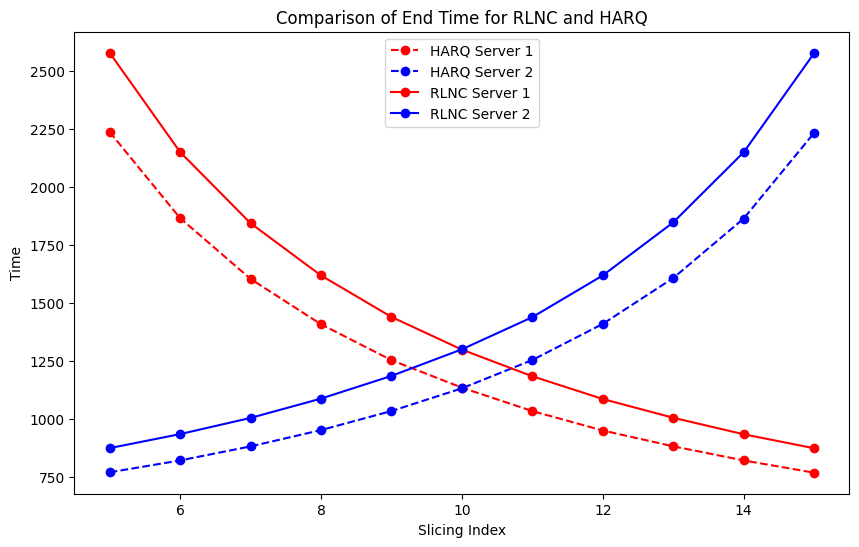

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

links = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

# Plot each line with specific color and label
plt.plot(links, total_results_time_1, color='red', label='HARQ Server 1', linestyle='--', marker='o')
plt.plot(links, total_results_time_2[::-1], color='blue', label='HARQ Server 2', linestyle='--', marker='o')
# plt.plot(links, best_total_results_time_1, color='green', label='HARQ Server 2', linestyle='--', marker='o')
# plt.plot(links, best_total_results_time_2[::-1], color='green', label='HARQ Server 2', linestyle='--', marker='o')
plt.plot(links, RLNC_total_results_time_1, color='red', label='RLNC Server 1', marker='o')
plt.plot(links, RLNC_total_results_time_2[::-1], color='blue', label='RLNC Server 2', marker='o')


# Adding labels and title
plt.xlabel('Slicing Index')
plt.ylabel('Time')
plt.title('Comparison of End Time for RLNC and HARQ')
plt.legend()

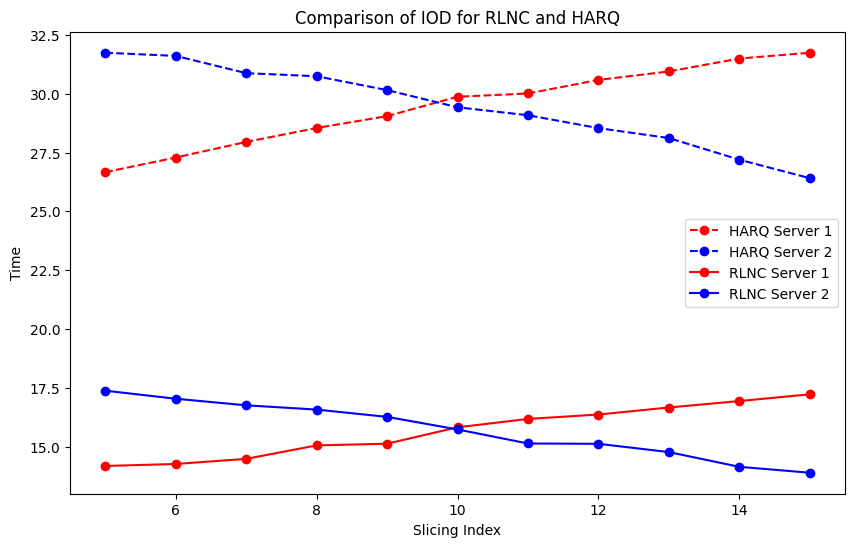

In [26]:
plt.figure(figsize=(10, 6))

# Plot each line with specific color and label
plt.plot(links, total_results_IOD_1, color='red', label='HARQ Server 1', linestyle='--', marker='o')
plt.plot(links, total_results_IOD_2[::-1], color='blue', label='HARQ Server 2', linestyle='--', marker='o')
# plt.plot(links, best_total_results_PPD_1, color='green', label='HARQ Server 2', linestyle='--', marker='o')
# plt.plot(links, best_total_results_PPD_2[::-1], color='green', label='HARQ Server 2', linestyle='--', marker='o')
plt.plot(links, RLNC_total_results_IOD_1, color='red', label='RLNC Server 1', marker='o')
plt.plot(links, RLNC_total_results_IOD_2[::-1], color='blue', label='RLNC Server 2', marker='o')

# Adding labels and title
plt.xlabel('Slicing Index')
plt.ylabel('Time')
plt.title('Comparison of IOD for RLNC and HARQ')
plt.legend()

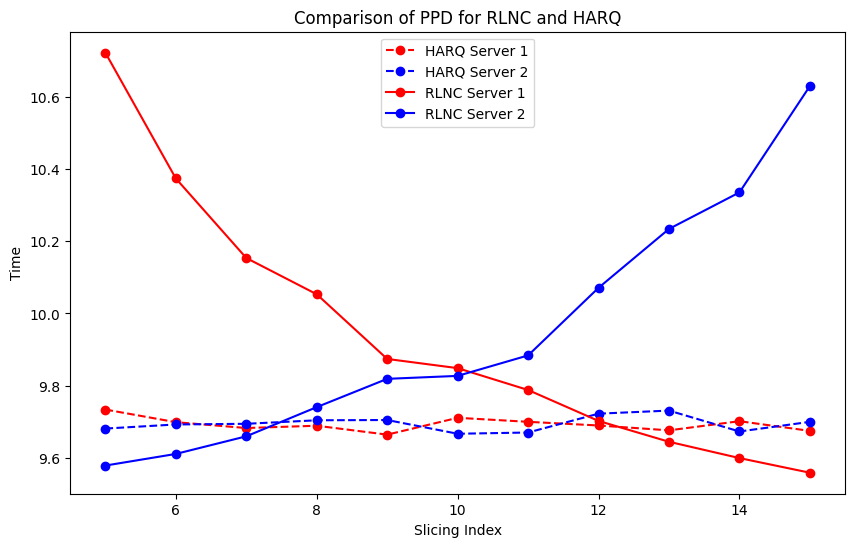

In [27]:
plt.figure(figsize=(10, 6))

# Plot each line with specific color and label
plt.plot(links, total_results_PPD_1, color='red', label='HARQ Server 1',linestyle='--', marker='o')
plt.plot(links, total_results_PPD_2[::-1], color='blue', label='HARQ Server 2', linestyle='--', marker='o')
plt.plot(links, RLNC_total_results_PPD_1, color='red', label='RLNC Server 1', marker='o')
plt.plot(links, RLNC_total_results_PPD_2[::-1], color='blue', label='RLNC Server 2', marker='o')

# Adding labels and title
plt.xlabel('Slicing Index')
plt.ylabel('Time')
plt.title('Comparison of PPD for RLNC and HARQ')
plt.legend()